In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['18GU','total'])
    lista_ine2.append(ine_ods[date].loc['013B','total'])
    lista_ine3.append(ine_ods[date].loc['021S','total'])
    lista_ine4.append(ine_ods[date].loc['219M','total'])
    lista_ine5.append(ine_ods[date].loc['01CA','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,3314
2020-04-02,3220
2020-04-03,3934
2020-04-04,3141
2020-04-05,2520


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,4188.802469
std,922.684743
min,2282.000000
25%,3503.000000
50%,4243.000000
75%,4933.000000
max,5827.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,3410.966667
2020-05-31,4262.193548
2020-06-30,5241.800000


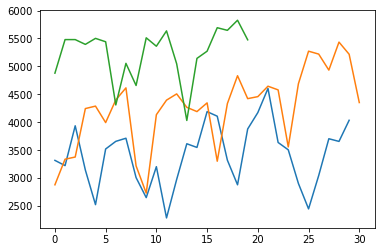

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.29111427]
  [0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]]

 [[0.26459807]
  [0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]]

 [[0.46600848]
  [0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]]

 [[0.24231315]
  [0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]]

 [[0.06713682]
  [0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]]

 [[0.3486601 ]
  [0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]]

 [[0.38730603]
  [0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]]

 [[0.40310293]
  [0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]]

 [[0.20394921]
  [0.10267985]
  [0.25923836]
  [0.        ]
  [0.19464034]
  [0.37517637]
  [0.3565585 ]]

 [[0.10267985]
  [0.25923836]
  [0.  

In [23]:
print(trainY)

[0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
 0.37517637 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998
 0.44992954 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006
 0.04569817 0.21438646 0.40056425 0.387024   0.49393517 0.16755998
 0.29703808 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707
 0.6578279  0.2631876  0.12552893 0.5221439  0.59576875 0.62736255
 0.5593794  0.5379408  0.58194643 0.28688294 0.57856137 0.719323
 0.60338503 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024
 0.84344155 0.82877296 0.7478139  0.88942176 0.8279267 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0219 - val_loss: 0.0332
Epoch 124/200
53/53 - 0s - loss: 0.0194 - val_loss: 0.0270
Epoch 125/200
53/53 - 0s - loss: 0.0214 - val_loss: 0.0323
Epoch 126/200
53/53 - 0s - loss: 0.0224 - val_loss: 0.0284
Epoch 127/200
53/53 - 0s - loss: 0.0200 - val_loss: 0.0276
Epoch 128/200
53/53 - 0s - loss: 0.0212 - val_loss: 0.0266
Epoch 129/200
53/53 - 0s - loss: 0.0187 - val_loss: 0.0224
Epoch 130/200
53/53 - 0s - loss: 0.0197 - val_loss: 0.0206
Epoch 131/200
53/53 - 0s - loss: 0.0223 - val_loss: 0.0231
Epoch 132/200
53/53 - 0s - loss: 0.0186 - val_loss: 0.0336
Epoch 133/200
53/53 - 0s - loss: 0.0197 - val_loss: 0.0325
Epoch 134/200
53/53 - 0s - loss: 0.0176 - val_loss: 0.0224
Epoch 135/200
53/53 - 0s - loss: 0.0211 - val_loss: 0.0197
Epoch 136/200
53/53 - 0s - loss: 0.0175 - val_loss: 0.0207
Epoch 137/200
53/53 - 0s - loss: 0.0204 - val_loss: 0.0208
Epoch 138/200
53/53 - 0s - loss: 0.0207 - val_loss: 0.0377
Epoch 139/200
53/53 - 0s - loss: 0.0209 - val_loss: 0.03

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 347.15 MAE
Resultado del entrenamiento: 187284.80 MSE
Resultado del entrenamiento: 432.76 RMSE
Resultado del entrenamiento: 11.09 CVRMSE
Resultado del entrenamiento: 9.85 MAPE 

Resultado del test: 428.53 MAE
Resultado del test: 260520.13 MSE
Resultado del test: 510.41 RMSE
Resultado del test: 9.83 CVRMSE
Resultado del test: 8.56 MAPE


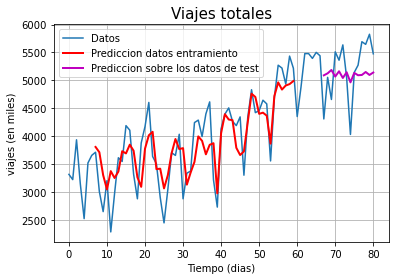

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

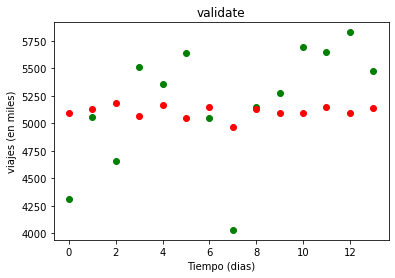

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

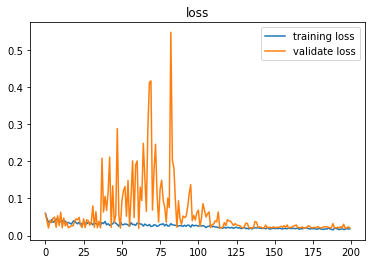

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

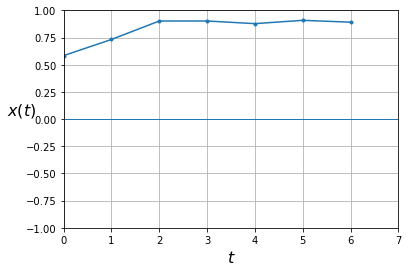

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,5090.070801
2020-06-08,5126.071289
2020-06-09,5186.072266
2020-06-10,5067.837402
2020-06-11,5162.968262
2020-06-12,5043.116211
2020-06-13,5145.549316
2020-06-14,4964.343262
2020-06-15,5133.624023
2020-06-16,5091.769043


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,4308,5090.070801
2020-06-08,5054,5126.071289
2020-06-09,4657,5186.072266
2020-06-10,5512,5067.837402
2020-06-11,5361,5162.968262
2020-06-12,5636,5043.116211
2020-06-13,5046,5145.549316
2020-06-14,4030,4964.343262
2020-06-15,5143,5133.624023
2020-06-16,5272,5091.769043


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.29111427 0.26459807 0.46600848 0.24231315 0.06713682 0.3486601
  0.38730603]
 [0.26459807 0.46600848 0.24231315 0.06713682 0.3486601  0.38730603
  0.40310293]
 [0.46600848 0.24231315 0.06713682 0.3486601  0.38730603 0.40310293
  0.20394921]
 [0.24231315 0.06713682 0.3486601  0.38730603 0.40310293 0.20394921
  0.10267985]
 [0.06713682 0.3486601  0.38730603 0.40310293 0.20394921 0.10267985
  0.25923836]
 [0.3486601  0.38730603 0.40310293 0.20394921 0.10267985 0.25923836
  0.        ]
 [0.38730603 0.40310293 0.20394921 0.10267985 0.25923836 0.
  0.19464034]
 [0.40310293 0.20394921 0.10267985 0.25923836 0.         0.19464034
  0.37517637]
 [0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
  0.3565585 ]
 [0.10267985 0.25923836 0.         0.19464034 0.37517637 0.3565585
  0.53765875]
 [0.25923836 0.         0.19464034 0.37517637 0.3565585  0.53765875
  0.5145275 ]
 [0.         0.19464034 0.37517637 0.3565585  0.53765875 0.5145275
  0.29196054]
 [0.19464034 0.37517637 0.3

In [43]:
print(trainY1)

[0.20394921 0.10267985 0.25923836 0.         0.19464034 0.37517637
 0.3565585  0.53765875 0.5145275  0.29196054 0.16755998 0.44992954
 0.5328632  0.65500706 0.38166434 0.34442878 0.17433006 0.04569817
 0.21438646 0.40056425 0.387024   0.49393517 0.16755998 0.29703808
 0.3080395  0.5531735  0.5655853  0.4823696  0.59689707 0.6578279
 0.2631876  0.12552893 0.5221439  0.59576875 0.62736255 0.5593794
 0.5379408  0.58194643 0.28688294 0.57856137 0.719323   0.60338503
 0.61354023 0.6662906  0.64767283 0.3590973  0.6787024  0.84344155
 0.82877296 0.7478139  0.88942176 0.8279267 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0273 - val_loss: 0.0750
Epoch 123/200
52/52 - 0s - loss: 0.0239 - val_loss: 0.1076
Epoch 124/200
52/52 - 0s - loss: 0.0260 - val_loss: 0.0709
Epoch 125/200
52/52 - 0s - loss: 0.0257 - val_loss: 0.1450
Epoch 126/200
52/52 - 0s - loss: 0.0235 - val_loss: 0.1367
Epoch 127/200
52/52 - 0s - loss: 0.0255 - val_loss: 0.1211
Epoch 128/200
52/52 - 0s - loss: 0.0245 - val_loss: 0.0386
Epoch 129/200
52/52 - 0s - loss: 0.0268 - val_loss: 0.0744
Epoch 130/200
52/52 - 0s - loss: 0.0269 - val_loss: 0.1000
Epoch 131/200
52/52 - 0s - loss: 0.0254 - val_loss: 0.1300
Epoch 132/200
52/52 - 0s - loss: 0.0263 - val_loss: 0.1008
Epoch 133/200
52/52 - 0s - loss: 0.0267 - val_loss: 0.0913
Epoch 134/200
52/52 - 0s - loss: 0.0246 - val_loss: 0.0970
Epoch 135/200
52/52 - 0s - loss: 0.0256 - val_loss: 0.0391
Epoch 136/200
52/52 - 0s - loss: 0.0257 - val_loss: 0.0449
Epoch 137/200
52/52 - 0s - loss: 0.0281 - val_loss: 0.0276
Epoch 138/200
52/52 - 0s - loss: 0.0270 - val_loss: 0.0725
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0411 - val_loss: 0.0479
Epoch 44/200
51/51 - 0s - loss: 0.0316 - val_loss: 0.0189
Epoch 45/200
51/51 - 0s - loss: 0.0311 - val_loss: 0.1596
Epoch 46/200
51/51 - 0s - loss: 0.0307 - val_loss: 0.0681
Epoch 47/200
51/51 - 0s - loss: 0.0375 - val_loss: 0.2961
Epoch 48/200
51/51 - 0s - loss: 0.0311 - val_loss: 0.1815
Epoch 49/200
51/51 - 0s - loss: 0.0378 - val_loss: 0.0729
Epoch 50/200
51/51 - 0s - loss: 0.0314 - val_loss: 0.0816
Epoch 51/200
51/51 - 0s - loss: 0.0369 - val_loss: 0.1729
Epoch 52/200
51/51 - 0s - loss: 0.0306 - val_loss: 0.3123
Epoch 53/200
51/51 - 0s - loss: 0.0356 - val_loss: 0.1621
Epoch 54/200
51/51 - 0s - loss: 0.0376 - val_loss: 0.0181
Epoch 55/200
51/51 - 0s - loss: 0.0323 - val_loss: 0.1410
Epoch 56/200
51/51 - 0s - loss: 0.0336 - val_loss: 0.0963
Epoch 57/200
51/51 - 0s - loss: 0.0300 - val_loss: 0.1709
Epoch 58/200
51/51 - 0s - loss: 0.0295 - val_loss: 0.1971
Epoch 59/200
51/51 - 0s - loss: 0.0321 - val_loss: 0.2368
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0229 - val_loss: 0.0568
Epoch 184/200
51/51 - 0s - loss: 0.0248 - val_loss: 0.0357
Epoch 185/200
51/51 - 0s - loss: 0.0242 - val_loss: 0.0498
Epoch 186/200
51/51 - 0s - loss: 0.0251 - val_loss: 0.0477
Epoch 187/200
51/51 - 0s - loss: 0.0236 - val_loss: 0.0216
Epoch 188/200
51/51 - 0s - loss: 0.0257 - val_loss: 0.0784
Epoch 189/200
51/51 - 0s - loss: 0.0254 - val_loss: 0.0565
Epoch 190/200
51/51 - 0s - loss: 0.0214 - val_loss: 0.0440
Epoch 191/200
51/51 - 0s - loss: 0.0208 - val_loss: 0.0511
Epoch 192/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.0736
Epoch 193/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0407
Epoch 194/200
51/51 - 0s - loss: 0.0208 - val_loss: 0.1569
Epoch 195/200
51/51 - 0s - loss: 0.0255 - val_loss: 0.0309
Epoch 196/200
51/51 - 0s - loss: 0.0223 - val_loss: 0.0542
Epoch 197/200
51/51 - 0s - loss: 0.0223 - val_loss: 0.1817
Epoch 198/200
51/51 - 0s - loss: 0.0252 - val_loss: 0.0673
Epoch 199/200
51/51 - 0s - loss: 0.0211 - val_loss: 0.03

50/50 - 0s - loss: 0.0246 - val_loss: 0.3400
Epoch 105/200
50/50 - 0s - loss: 0.0239 - val_loss: 0.4298
Epoch 106/200
50/50 - 0s - loss: 0.0279 - val_loss: 0.3627
Epoch 107/200
50/50 - 0s - loss: 0.0286 - val_loss: 0.2049
Epoch 108/200
50/50 - 0s - loss: 0.0235 - val_loss: 0.2760
Epoch 109/200
50/50 - 0s - loss: 0.0217 - val_loss: 0.1967
Epoch 110/200
50/50 - 0s - loss: 0.0228 - val_loss: 0.2908
Epoch 111/200
50/50 - 0s - loss: 0.0226 - val_loss: 0.1125
Epoch 112/200
50/50 - 0s - loss: 0.0280 - val_loss: 0.1286
Epoch 113/200
50/50 - 0s - loss: 0.0269 - val_loss: 0.1426
Epoch 114/200
50/50 - 0s - loss: 0.0239 - val_loss: 0.1757
Epoch 115/200
50/50 - 0s - loss: 0.0218 - val_loss: 0.0580
Epoch 116/200
50/50 - 0s - loss: 0.0254 - val_loss: 0.0784
Epoch 117/200
50/50 - 0s - loss: 0.0217 - val_loss: 0.1130
Epoch 118/200
50/50 - 0s - loss: 0.0248 - val_loss: 0.1634
Epoch 119/200
50/50 - 0s - loss: 0.0211 - val_loss: 0.2379
Epoch 120/200
50/50 - 0s - loss: 0.0270 - val_loss: 0.2739
Epoch 121/2

49/49 - 0s - loss: 0.0372 - val_loss: 0.0322
Epoch 25/200
49/49 - 0s - loss: 0.0346 - val_loss: 0.0162
Epoch 26/200
49/49 - 0s - loss: 0.0399 - val_loss: 0.0179
Epoch 27/200
49/49 - 0s - loss: 0.0336 - val_loss: 0.0169
Epoch 28/200
49/49 - 0s - loss: 0.0337 - val_loss: 0.0217
Epoch 29/200
49/49 - 0s - loss: 0.0328 - val_loss: 0.0159
Epoch 30/200
49/49 - 0s - loss: 0.0308 - val_loss: 0.1394
Epoch 31/200
49/49 - 0s - loss: 0.0312 - val_loss: 0.0943
Epoch 32/200
49/49 - 0s - loss: 0.0300 - val_loss: 0.1589
Epoch 33/200
49/49 - 0s - loss: 0.0258 - val_loss: 0.2729
Epoch 34/200
49/49 - 0s - loss: 0.0286 - val_loss: 0.0373
Epoch 35/200
49/49 - 0s - loss: 0.0423 - val_loss: 0.1647
Epoch 36/200
49/49 - 0s - loss: 0.0334 - val_loss: 0.0398
Epoch 37/200
49/49 - 0s - loss: 0.0298 - val_loss: 0.2146
Epoch 38/200
49/49 - 0s - loss: 0.0269 - val_loss: 0.2219
Epoch 39/200
49/49 - 0s - loss: 0.0340 - val_loss: 0.2760
Epoch 40/200
49/49 - 0s - loss: 0.0313 - val_loss: 0.2997
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0211 - val_loss: 0.0886
Epoch 166/200
49/49 - 0s - loss: 0.0208 - val_loss: 0.0891
Epoch 167/200
49/49 - 0s - loss: 0.0212 - val_loss: 0.1386
Epoch 168/200
49/49 - 0s - loss: 0.0222 - val_loss: 0.2040
Epoch 169/200
49/49 - 0s - loss: 0.0225 - val_loss: 0.2340
Epoch 170/200
49/49 - 0s - loss: 0.0249 - val_loss: 0.2380
Epoch 171/200
49/49 - 0s - loss: 0.0218 - val_loss: 0.1621
Epoch 172/200
49/49 - 0s - loss: 0.0220 - val_loss: 0.2051
Epoch 173/200
49/49 - 0s - loss: 0.0241 - val_loss: 0.4356
Epoch 174/200
49/49 - 0s - loss: 0.0212 - val_loss: 0.3107
Epoch 175/200
49/49 - 0s - loss: 0.0226 - val_loss: 0.1175
Epoch 176/200
49/49 - 0s - loss: 0.0204 - val_loss: 0.1749
Epoch 177/200
49/49 - 0s - loss: 0.0198 - val_loss: 0.1956
Epoch 178/200
49/49 - 0s - loss: 0.0210 - val_loss: 0.2024
Epoch 179/200
49/49 - 0s - loss: 0.0235 - val_loss: 0.4379
Epoch 180/200
49/49 - 0s - loss: 0.0247 - val_loss: 0.2032
Epoch 181/200
49/49 - 0s - loss: 0.0211 - val_loss: 0.25

Epoch 86/200
48/48 - 0s - loss: 0.0263 - val_loss: 0.3299
Epoch 87/200
48/48 - 0s - loss: 0.0233 - val_loss: 0.6094
Epoch 88/200
48/48 - 0s - loss: 0.0229 - val_loss: 0.5027
Epoch 89/200
48/48 - 0s - loss: 0.0217 - val_loss: 0.7948
Epoch 90/200
48/48 - 0s - loss: 0.0199 - val_loss: 0.7703
Epoch 91/200
48/48 - 0s - loss: 0.0212 - val_loss: 0.6954
Epoch 92/200
48/48 - 0s - loss: 0.0210 - val_loss: 0.4307
Epoch 93/200
48/48 - 0s - loss: 0.0245 - val_loss: 0.5467
Epoch 94/200
48/48 - 0s - loss: 0.0189 - val_loss: 0.9356
Epoch 95/200
48/48 - 0s - loss: 0.0245 - val_loss: 0.4546
Epoch 96/200
48/48 - 0s - loss: 0.0261 - val_loss: 0.0930
Epoch 97/200
48/48 - 0s - loss: 0.0225 - val_loss: 0.3777
Epoch 98/200
48/48 - 0s - loss: 0.0262 - val_loss: 0.0984
Epoch 99/200
48/48 - 0s - loss: 0.0244 - val_loss: 0.1271
Epoch 100/200
48/48 - 0s - loss: 0.0227 - val_loss: 0.2896
Epoch 101/200
48/48 - 0s - loss: 0.0200 - val_loss: 0.3795
Epoch 102/200
48/48 - 0s - loss: 0.0230 - val_loss: 0.5323
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0409 - val_loss: 0.0264
Epoch 7/200
47/47 - 0s - loss: 0.0551 - val_loss: 0.0420
Epoch 8/200
47/47 - 0s - loss: 0.0450 - val_loss: 0.0865
Epoch 9/200
47/47 - 0s - loss: 0.0445 - val_loss: 0.0488
Epoch 10/200
47/47 - 0s - loss: 0.0531 - val_loss: 0.0914
Epoch 11/200
47/47 - 0s - loss: 0.0448 - val_loss: 0.1527
Epoch 12/200
47/47 - 0s - loss: 0.0458 - val_loss: 0.0796
Epoch 13/200
47/47 - 0s - loss: 0.0430 - val_loss: 0.1114
Epoch 14/200
47/47 - 0s - loss: 0.0422 - val_loss: 0.0802
Epoch 15/200
47/47 - 0s - loss: 0.0410 - val_loss: 0.0386
Epoch 16/200
47/47 - 0s - loss: 0.0452 - val_loss: 0.0665
Epoch 17/200
47/47 - 0s - loss: 0.0425 - val_loss: 0.0449
Epoch 18/200
47/47 - 0s - loss: 0.0367 - val_loss: 0.0711
Epoch 19/200
47/47 - 0s - loss: 0.0365 - val_loss: 0.0537
Epoch 20/200
47/47 - 0s - loss: 0.0446 - val_loss: 0.0843
Epoch 21/200
47/47 - 0s - loss: 0.0436 - val_loss: 0.0360
Epoch 22/200
47/47 - 0s - loss: 0.0440 - val_loss: 0.0271
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0142 - val_loss: 0.0305
Epoch 148/200
47/47 - 0s - loss: 0.0106 - val_loss: 0.0293
Epoch 149/200
47/47 - 0s - loss: 0.0137 - val_loss: 0.0253
Epoch 150/200
47/47 - 0s - loss: 0.0142 - val_loss: 0.0253
Epoch 151/200
47/47 - 0s - loss: 0.0123 - val_loss: 0.0187
Epoch 152/200
47/47 - 0s - loss: 0.0189 - val_loss: 0.0383
Epoch 153/200
47/47 - 0s - loss: 0.0148 - val_loss: 0.0032
Epoch 154/200
47/47 - 0s - loss: 0.0154 - val_loss: 0.0495
Epoch 155/200
47/47 - 0s - loss: 0.0154 - val_loss: 0.0202
Epoch 156/200
47/47 - 0s - loss: 0.0156 - val_loss: 0.0480
Epoch 157/200
47/47 - 0s - loss: 0.0149 - val_loss: 0.0569
Epoch 158/200
47/47 - 0s - loss: 0.0137 - val_loss: 0.0353
Epoch 159/200
47/47 - 0s - loss: 0.0141 - val_loss: 0.0512
Epoch 160/200
47/47 - 0s - loss: 0.0127 - val_loss: 0.0569
Epoch 161/200
47/47 - 0s - loss: 0.0182 - val_loss: 0.0720
Epoch 162/200
47/47 - 0s - loss: 0.0159 - val_loss: 0.0541
Epoch 163/200
47/47 - 0s - loss: 0.0129 - val_loss: 0.09

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.59159696]
 [0.91537714]
 [0.8276173 ]
 [0.91663   ]
 [0.9081871 ]
 [1.0466478 ]
 [0.05699609]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[4992],
       [5343],
       [5248],
       [5345],
       [5335],
       [5486],
       [4413]])

# Visualizamos el pronostico

<AxesSubplot:>

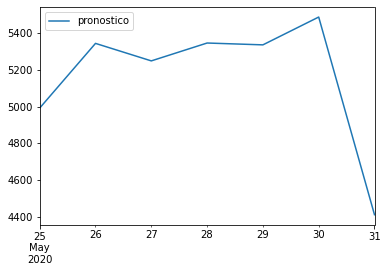

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,4688,4992
2020-05-26,5272,5343
2020-05-27,5220,5248
2020-05-28,4933,5345
2020-05-29,5435,5335
2020-05-30,5217,5486
2020-05-31,4351,4413


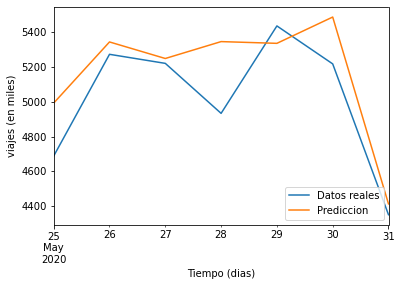

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 178.00 MAE
Resultado del test: 50598.57 MSE
Resultado del test: 224.94 RMSE
Resultado del test: 4.35 CVRMSE
Resultado del test: 3.41 MAPE
